In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as ss

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# set some styling defaults for matplotlib
plt.style.use("seaborn-talk")
mpl.rcParams["figure.dpi"] = 90  # change this to set apparent figure size
mpl.rcParams["figure.figsize"] = (7, 3)
mpl.rcParams["figure.frameon"] = False

# set decimal precision to 3 dec. places
%precision 3

'%.3f'

In [2]:
# %pip install scikit-optimize
# uncomment and run the above if you don't have skopt installed

In [3]:
import skopt

# Bayesian optimisation

## Outcomes

* How Bayesian optimisation works
* How to build proxy functions 
* How to choose acquisition functions 
* How to apply BO to problems of tuning interfaces

# Goal
* Formulate a problem as a mapping from parameters (things we can adjust) to an objective (a single numerical measure of goodness) 
    * This is an "objective function" 
* Optimise (i.e. tweak parameters) to maximise the objective function; this should maximise the goodness of our configuration.
* *Do this without knowing what the objective function is!*
* Instead, make measurements of the real world for a few specific, definite values of the parameters and optimise based on a (distribution over) *proxy objective function*
* We want to do this such that we:
    * Spend the least time possible making measurements.
    * Cope with the face that the real world is noisy.

## Task
We will model a problem of optimising reading speed on a mobile device. There are many things we can alter in page layout: margins, font size, font shape, line spacing, etc. We don't have a good model of what effect these have on reading speed, but if we're building a device that is supposed to help users read quickly (note that this is a very narrow choice of optimality!) then we need to establish one.

<img src="reading_kindle.png">

### Optimising font size
We'll stick to just one variable for the moment, *font size*

Our problem can be written as:

* minimise reading time for a given text and font size

Formal optimisation would express this as:

$$\theta^* = \operatorname{argmin}_\theta f(x;\theta)\ \text{s.t.}\ c(\theta)>0$$

$\theta^*$ is the configuration we're looking for; $x$ is the text the reader is reading; and $\theta$ is the parameters, which in this case is just one number: font size. We also have some basic constraints: font size must be positive and less than some maximum font size; $c(\theta)$ represents this constraint in the equation above.

We don't know what $f(x;\theta)$ is *but* we can evaluate it pointwise: choose a specific $x$ and a specific $\theta$ (i.e. a text and a font size), give it to a user, and ask them to read the text. We time how long they take, and that is the measure at that specific instant. Obviously, this is a bit noisy, but that's okay.

## Process

* Create a prior distribution over proxy objective function (i.e. guesses for what $f(x;\theta)$ might look like)
* Decide on a rule to choose the next experiment to run. This is given by the **acquisition function**, which outputs a new $\theta$ given a distribution over $f(x;\theta)$.
* Apply the rule to choose a specific $\theta$, run the experiment, update the distribution to get a posterior.

We'll use a flexible class of models called **Gaussian Processes**: the details don't really matter here, but they give a really simple way to form distributions over continuous functions even when we know very little about their form of those functions. They are "properly" probabilistic, and inferring posteriors (over functions) given definite but noisy observations is a standard operation.

## Package: `skopt`
`skopt` is a basic package that makes it easy to implement basic Bayesian optimisation. It gives us the ability to specify distributions over functions as GPs, and then a selection of acquisition functions to decide on the next optimal point to choose.


## Setup
We don't have enough time to run real experiments. So I've created a simulator -- a black box -- that will simulate reading documents. It takes a text and a font size and returns the number of seconds to read that text on a small mobile screen.

In [4]:
from simulate_reading import read_text, word_count

# return value is in seconds
read_text("The long brown cat jumped over the slippery dog", font_size=6)

13.528879021487764

In [5]:
with open("war_peace.txt", encoding="utf8") as f:
    war_peace = f.read()

read_text(war_peace)    

571923.6958382742

In [6]:
read_text(war_peace, font_size=16)    

921233.8127854249

In [7]:
read_text(war_peace, font_size=4)    

845611.3287097312

In [8]:
def war_peace_wps(font_size, portion=1.0):
    # normalise to be seconds/word
    text = war_peace[:int(len(war_peace)*portion)]
    time = read_text(text, font_size)
    wc = word_count(text)
    return time / wc

### A simple Gaussian Process

In [9]:
from skopt.learning.gaussian_process import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import RBF

import scipy.stats
from gp_utils import render_gp, ei, pi, lcb, plot_gp_samples

#### Sampling

A Gaussan Process (GP) is a distribution over functions, so we can sample from it, to get plausible functions (curves).

In [10]:
font_sizes = np.linspace(1, 28, 100)

In [11]:
basic_gp = GaussianProcessRegressor(kernel = RBF(3.0, "fixed"))
ys = basic_gp.sample_y(font_sizes[:, None], 10)

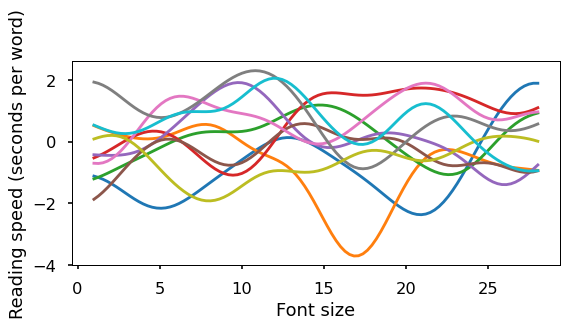

In [12]:
fig, ax = plt.subplots()
plot_gp_samples(ax, font_sizes, ys)

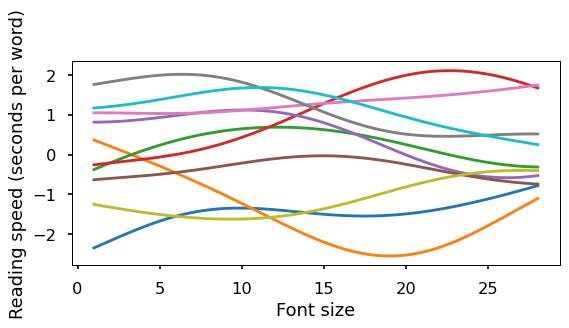

In [13]:
basic_gp = GaussianProcessRegressor(kernel = RBF(10.0, "fixed"))
ys = basic_gp.sample_y(font_sizes[:, None], 10)
fig, ax = plt.subplots()
plot_gp_samples(ax, font_sizes, ys)

#### Distribution over functions
We have a whole distribution over functions, though it is very boring looking since we're averageing over *every* possible smooth function.

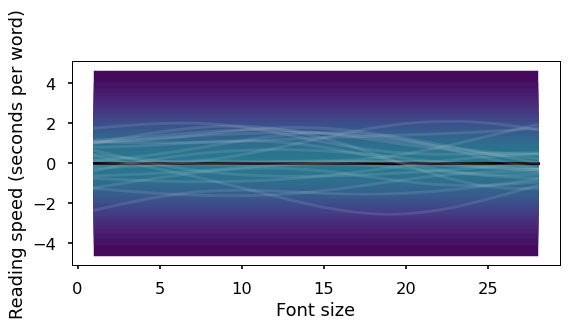

In [14]:
fig, ax = plt.subplots()
render_gp(ax, font_sizes, basic_gp)

### A data point
We can perform Bayesian inference, by computing the likelihood of an observation under every possible function, and then reweighting to place more density on those functions that are compatible, exactly as we have done before.


In [15]:
font_size = 12
t_12 = war_peace_wps(font_size)

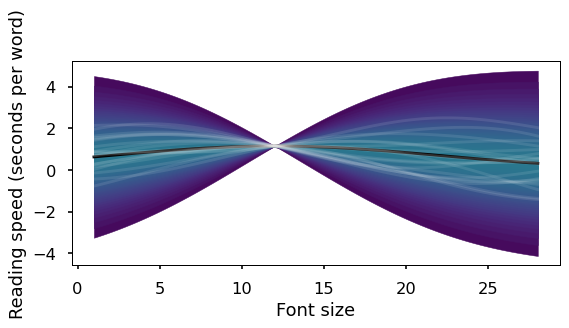

In [17]:
font_gp = GaussianProcessRegressor(kernel = RBF(10.0, "fixed"))
font_gp.fit([[font_size]], [t_12])

fig, ax = plt.subplots()
render_gp(ax, font_sizes, font_gp)

#### Noise
Typically, running a human subject experiment doesn't give a definite answer. Instead, we'd be more cautious and assume that the data generating process produced a reading time *plus some noise*. We can easily configure the GP to account for our (estimated) noise by setting the $\alpha$ parameter:

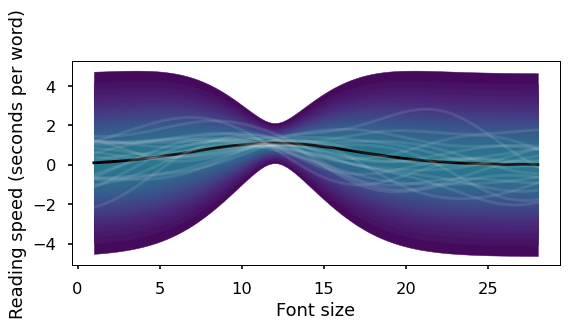

In [18]:
# with some uncertainty on outputs
font_gp_noise = GaussianProcessRegressor(kernel = RBF(5.0, "fixed"), alpha=0.05)
font_gp_noise.fit(np.array([[font_size]]), np.array([t_12]))

fig, ax = plt.subplots()
render_gp(ax, font_sizes, font_gp_noise)

### Acquisition function
We now use an acquisition function to obtain a definite point to measure (i.e. a new experiment to run), given a distribution over functions.

We could work out what value would give us the largest average increase (**expected improvement** or EI) in our estimate. We can also compute the **probability of improvement** (PI) and the **lower confidence bound** (LCB). The choice between these doesn't make a huge difference in our example, but they imply slightly different choices for the search process. In each case, we evaluate the AF across the domain, and choose the optimal value as the next point to test.


Text(0, 0.5, 'LCB')

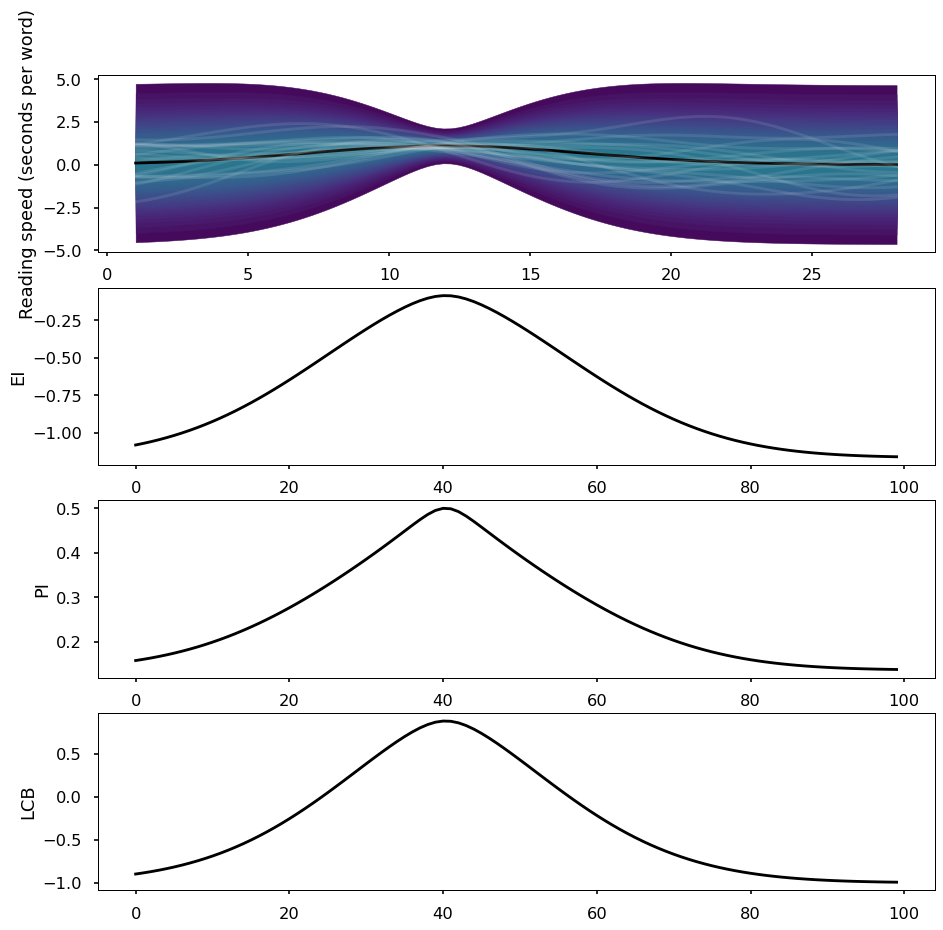

In [19]:
fig, ax = plt.subplots(nrows=4, figsize=(12, 12))
render_gp(ax[0], font_sizes, font_gp_noise)

y_mean, y_std = font_gp_noise.predict(font_sizes[:, None], return_std=True)
exp_improvement = ei(y_mean, y_std)
ax[1].plot(exp_improvement, c='k')
ax[1].set_ylabel("EI")


pred_improvement = pi(y_mean, y_std)
ax[2].plot(pred_improvement, c='k')
ax[2].set_ylabel("PI")


lcb_improvement = lcb(y_mean, y_std, kappa=1)
ax[3].plot(lcb_improvement, c='k')
ax[3].set_ylabel("LCB")



## Applying
Now we can run this in a loop -- at each point, we choose a point than optimises an acquisition function, then run an experiment (calculate reading time) at that point.

We make our subjects read the *whole* of War and Peace -- this reduces variation, but increases the time for each acquisition.

In [21]:
def fit_predict_gp(xs, ys, noise):
    gp = GaussianProcessRegressor(kernel=RBF(5.0, "fixed"), alpha=noise)
    if len(xs)>0:
        gp.fit(np.array(xs).reshape(-1, 1), np.array(ys))
    y_pred, y_std = gp.predict(font_sizes.reshape((-1, 1)), return_std=True)
    return y_pred, y_std, gp

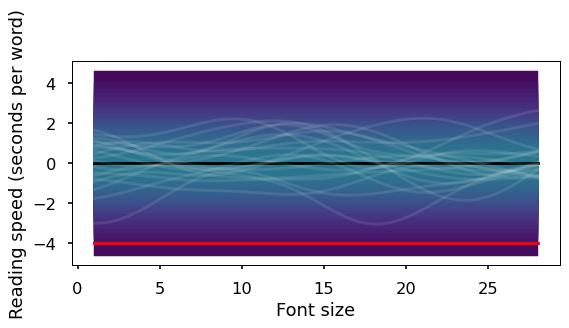

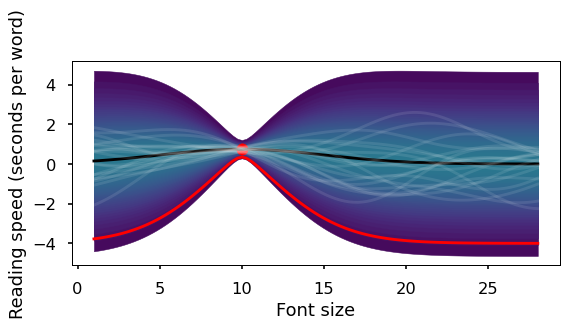

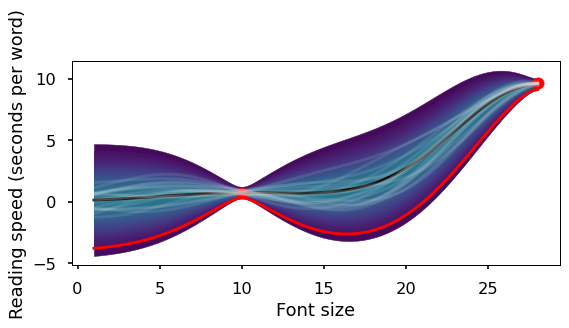

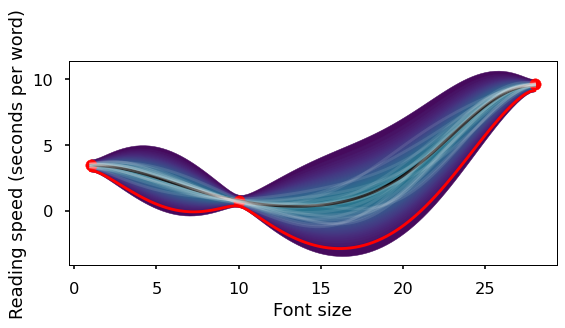

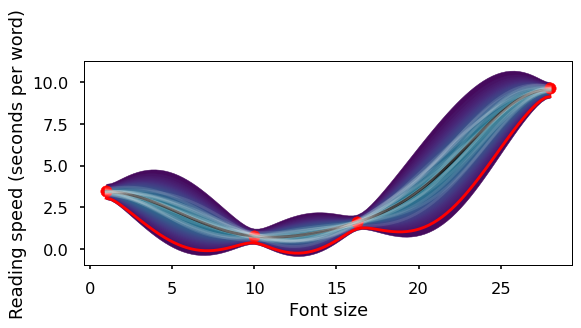

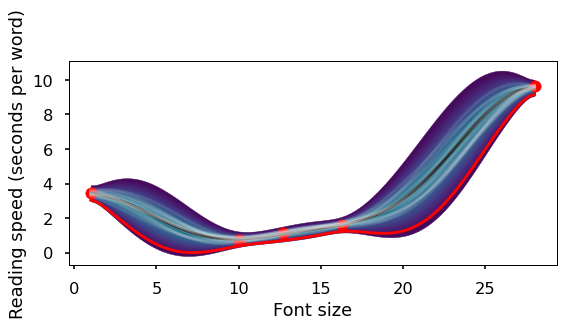

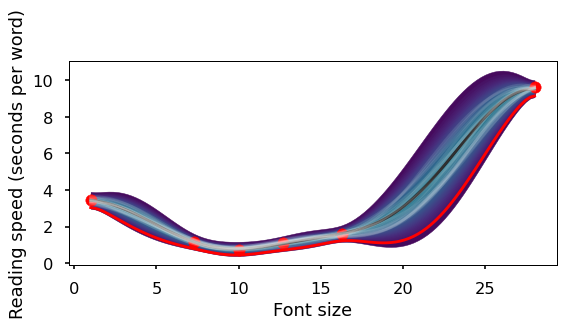

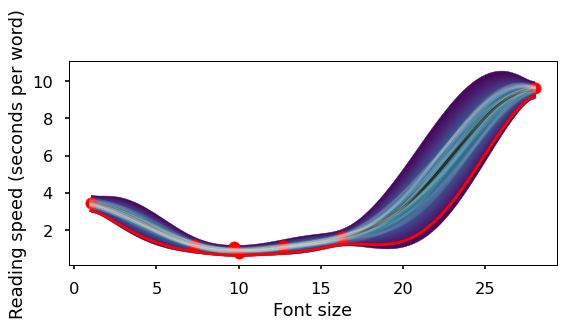

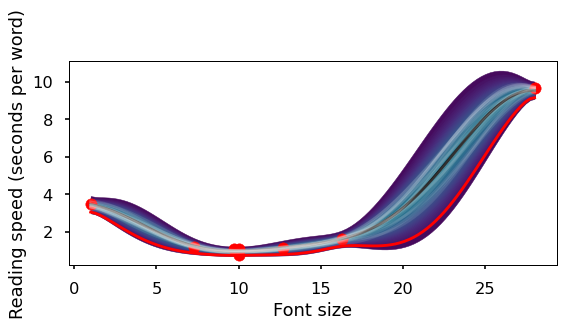

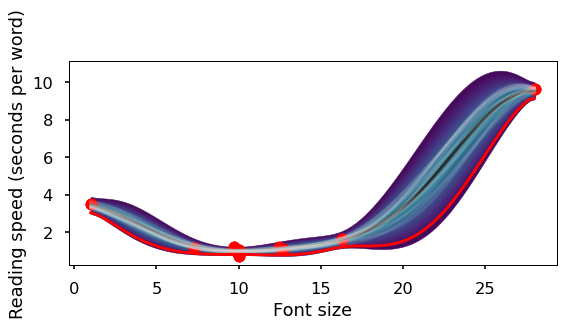

In [22]:
test_fonts = []
test_times = []

for i in range(10):
    # fit GP    
    y_pred, y_std, gp = fit_predict_gp(test_fonts, test_times, noise=0.01)
    # use lower confidence bound
    exp_imp = lcb(y_pred, y_std, kappa=4) 
    # find biggest improvement    
    next_font = font_sizes[np.argmin(exp_imp)]    
    # perform the experiment
    time = war_peace_wps(next_font)
    # plot the curve
    fig, ax = plt.subplots()    
    render_gp(ax, font_sizes, gp)
    ax.scatter(test_fonts, test_times, c="r")
    ax.plot(font_sizes, exp_imp, c='r')
    
    # store the result
    test_fonts.append(next_font)
    test_times.append(time)

    
ax.scatter(test_fonts, test_times, c="r")    
    

In [23]:
print(test_fonts)

[10.0, 28.0, 1.0, 16.272727272727273, 12.727272727272727, 7.2727272727272725, 9.727272727272727, 10.0, 9.727272727272727, 12.454545454545453]


### More noise
We could ask subjects to just read the first ten or so pages, and extrapolate from there. This is quick, but noisier -- but we can easily accommodate that in our model.

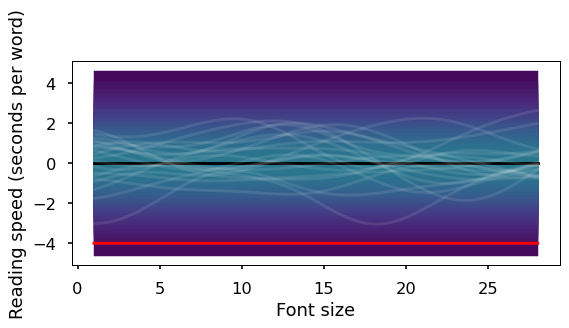

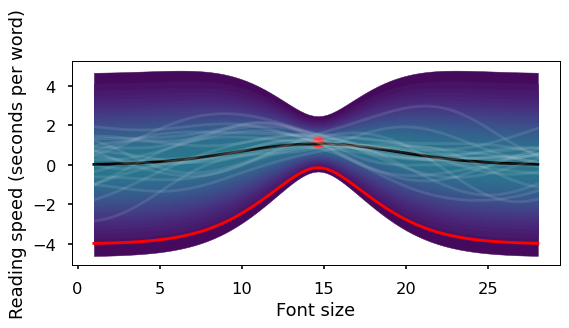

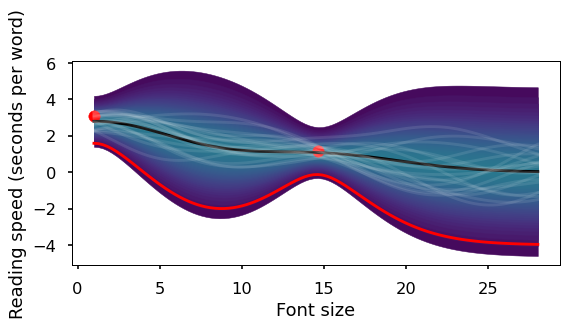

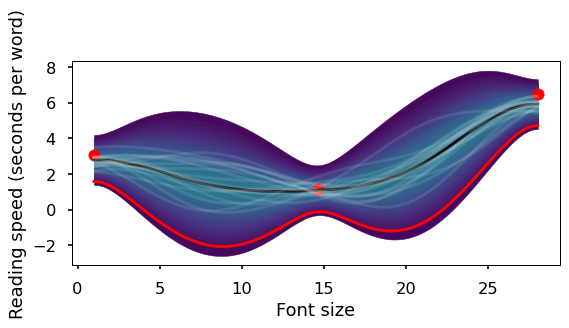

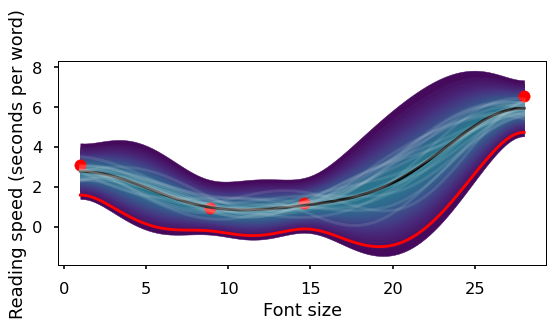

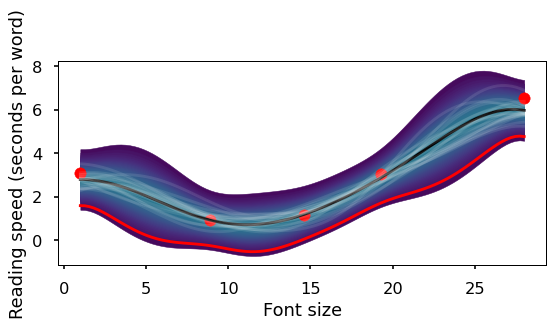

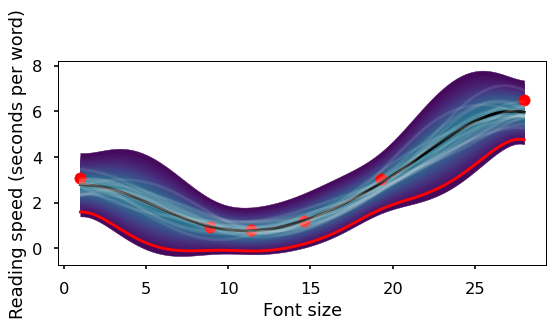

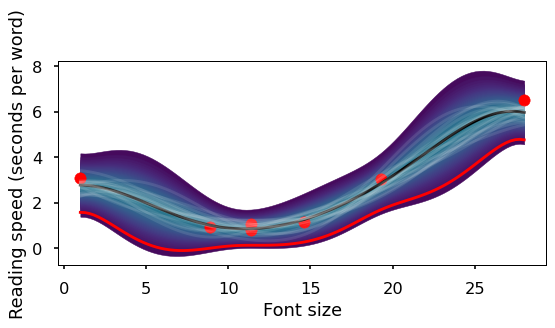

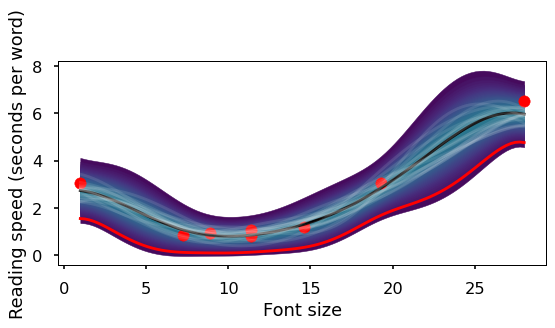

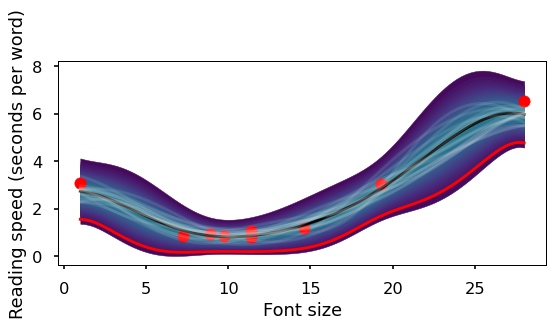

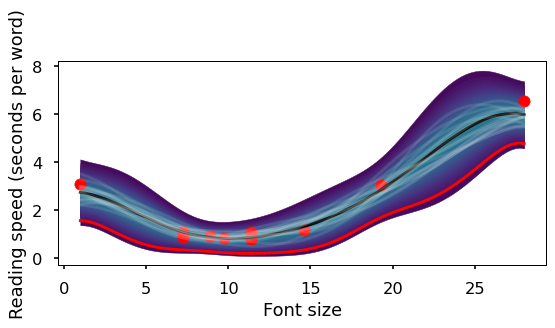

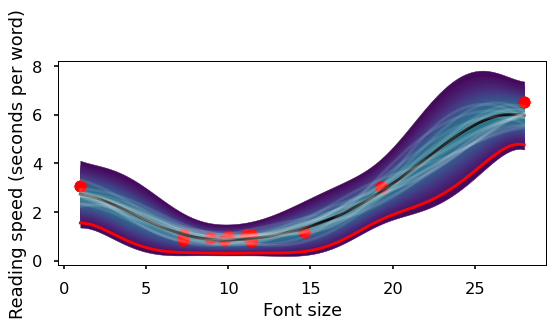

In [24]:
test_fonts = []
test_times = []

for i in range(12):
    # fit GP    
    y_pred, y_std, gp = fit_predict_gp(test_fonts, test_times, noise=0.1)
    # use lower confidence bound
    exp_imp = lcb(y_pred, y_std, kappa=4) 
    # find biggest improvement    
    next_font = font_sizes[np.argmin(exp_imp)]    
    # perform the experiment
    time = war_peace_wps(next_font, portion=0.01)
    # plot the curve
    fig, ax = plt.subplots()    
    render_gp(ax, font_sizes, gp)
    ax.scatter(test_fonts, test_times, c="r")
    ax.plot(font_sizes, exp_imp, c='r')
    
    # store the result
    test_fonts.append(next_font)
    test_times.append(time)

    
ax.scatter(test_fonts, test_times, c="r")  

### Notes: automatic Bayesian optimisation
Note that I've manually executed this loop to show you the process in detail. `skopt` would normally be used in an automatic mode, where it would optimise sequentially without intervention. It can do clever things, like take into account the expected time to run an experiment, or hedge against a bad choice of acquisition function by optimising that choice online as well.

In [25]:
result = skopt.gp_minimize(lambda x:war_peace_wps(x[0], portion=0.05),
                  [(1.0, 30.0)], # range
                  acq_func='LCB', # acquisition function
                  n_initial_points = 1, # one initial random guess
                  n_calls = 10, # 10 iterations
                 noise=0.1) # noise level
print(result.x_iters)              

[[28.325160454218288], [1.0], [2.772147979150116], [10.626425562693456], [15.301437781373423], [8.46160269425715], [11.146276608555196], [8.768983344131868], [12.076415120735403], [11.82833014510644]]


## Reflection

### What did we gain?
* We have an efficient way to optimise parameters of an interface when it costs a lot to obtain real data. 
* We can deal with inaccurate or noisy measurements; we won't be misled by an occasional bad data point
* We *know how certain we are* -- whether or not it is worth continuing to run experiments or not.
* We only had to make very weak assumptions about the objective function: no complicated modelling required.

### What caused trouble?
* There are still choices to make about the appropriate acquisition function to choose
* and about the right "smoothness" of the proxy objective function.
* It's not necessarily obvious how to bring in other expert knowledge about the objective function (e.g. is always positive, monotonic, quadratic, or whatever).
* BO works well in small dimensions, but it isn't very efficient where there are many parameters to optimise at once.
* This isn't easy to apply to tasks like layout, ranking, etc. where discrete optimisation is required.

### What else could we do?
* We only optimised in one dimension here; realistically,  we'd be likely to be optimising over a few dimensions at once.
* We only considered pure sequential experiments. We can also compute the acquisition function for multiple simultaneous experiments; though the computation becomes more intensive if we want to do this optimally.